In [21]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")


In [22]:
# load sample dataset
# from pycaret.datasets import get_data
# data = get_data('diabetes')
import pandas as pd

# 1. 从本地 CSV 读取
data = pd.read_csv('diabetes.csv')   # 路径按实际修改

In [23]:
import numpy as np
import pandas as pd
from scipy import sparse

def is_lowdim_dense(df,
                    max_dim=1000,
                    max_sparsity=0.05,
                    max_mem_mb=500):
    """
    判断 DataFrame 是否属于“低维且稠密”数据
    
    参数
    ----
    df : pd.DataFrame
        原始数据
    max_dim : int
        维度上限（列数）
    max_sparsity : float
        稀疏率上限，0~1
    max_mem_mb : float
        预估稠密化后内存上限（MB），用于保守拦截
    
    返回
    ----
    flag : bool
        True -> 低维稠密，可放心喂 PyCaret
    report : dict
        详细指标
    """
    # 1. 维度检查
    n_row, n_col = df.shape
    dim_ok = n_col <= max_dim
    
    # 2. 稀疏率检查（只对数值列计算）
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        return False, {"reason": "无数值列"}
    
    # 转稀疏矩阵，统计 0 的比率
    sparse_mat = sparse.csr_matrix(df[num_cols].values)
    n_total = sparse_mat.shape[0] * sparse_mat.shape[1]
    n_zeros = n_total - sparse_mat.nnz
    sparsity = n_zeros / n_total
    
    sparse_ok = sparsity <= max_sparsity
    
    # 3. 内存检查（假设转成稠密 float64）
    est_mem_mb = n_row * n_col * 8 / 1024 / 1024
    mem_ok = est_mem_mb <= max_mem_mb
    
    flag = dim_ok and sparse_ok and mem_ok
    report = {
        "n_rows": n_row,
        "n_cols": n_col,
        "dim_ok": dim_ok,
        "sparsity": round(sparsity, 3),
        "sparse_ok": sparse_ok,
        "est_dense_mem_MB": round(est_mem_mb, 1),
        "mem_ok": mem_ok,
    }
    return flag, report



print("data:", is_lowdim_dense(data,max_sparsity=0.20))
    

data: (True, {'n_rows': 768, 'n_cols': 9, 'dim_ok': True, 'sparsity': 0.183, 'sparse_ok': True, 'est_dense_mem_MB': 0.1, 'mem_ok': True})


In [24]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(data, target = 'Class variable', session_id = 123, log_experiment=True, experiment_name='diabetes')

,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


2025/12/23 03:05:09 INFO mlflow.tracking.fluent: Experiment with name 'diabetes' does not exist. Creating a new experiment.
2025/12/23 03:05:09 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [25]:
# OOP API
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7689,0.8047,0.5602,0.7208,0.6279,0.4641,0.4736,0.0060
ridge,Ridge Classifier,0.7670,0.0000,0.5497,0.7235,0.6221,0.4581,0.4690,0.0040
lda,Linear Discriminant Analysis,0.7670,0.8055,0.5550,0.7202,0.6243,0.4594,0.4695,0.0060
rf,Random Forest Classifier,0.7485,0.7911,0.5284,0.6811,0.5924,0.4150,0.4238,0.0170
nb,Naive Bayes,0.7427,0.7955,0.5702,0.6543,0.6043,0.4156,0.4215,0.0050
catboost,CatBoost Classifier,0.7410,0.7993,0.5278,0.6630,0.5851,0.4005,0.4078,0.0270
gbc,Gradient Boosting Classifier,0.7373,0.7917,0.5550,0.6445,0.5931,0.4013,0.4059,0.0170
ada,Ada Boost Classifier,0.7372,0.7799,0.5275,0.6585,0.5796,0.3926,0.4017,0.0130
et,Extra Trees Classifier,0.7299,0.7788,0.4965,0.6516,0.5596,0.3706,0.3802,0.0220
qda,Quadratic Discriminant Analysis,0.7282,0.7894,0.5281,0.6558,0.5736,0.3785,0.3910,0.0050


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [26]:
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


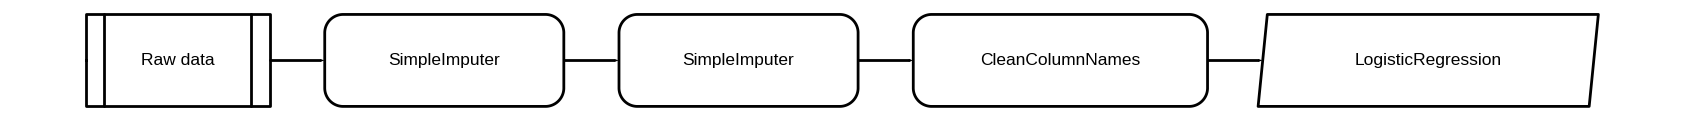

In [27]:
# OOP API
s.evaluate_model(best)

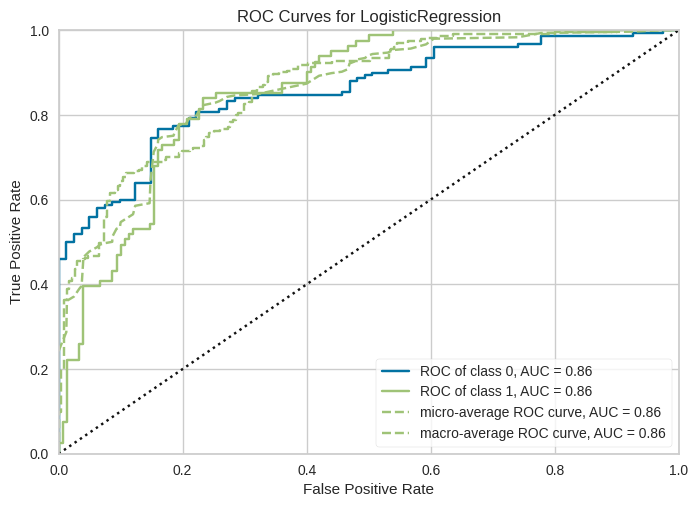

In [28]:
# OOP API
s.plot_model(best, plot = 'auc')

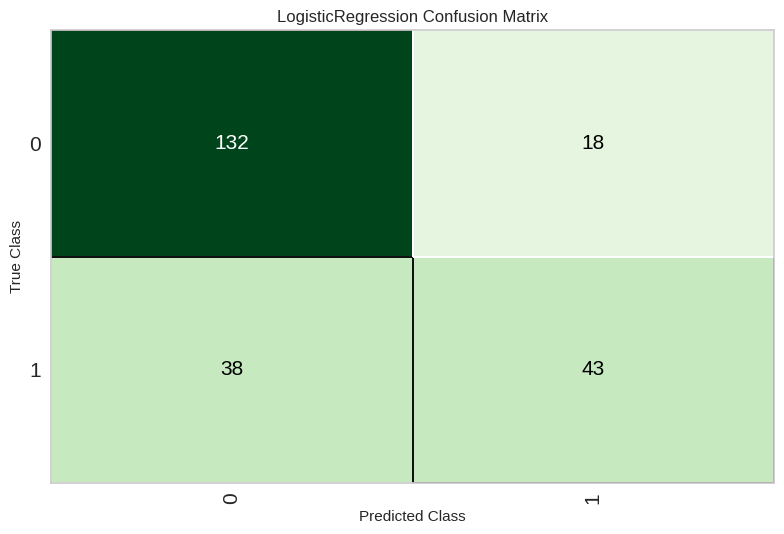

In [29]:
# OOP API
s.plot_model(best, plot = 'confusion_matrix')

In [30]:
# OOP API
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7576,0.8568,0.5309,0.7049,0.6056,0.4356,0.4447


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,prediction_label,prediction_score
552,6,114,88,0,0,27.799999,0.247,66,0,0,0.8037
438,1,97,70,15,0,18.200001,0.147,21,0,0,0.9648
149,2,90,70,17,0,27.299999,0.085,22,0,0,0.9394
373,2,105,58,40,94,34.900002,0.225,25,0,0,0.7999
36,11,138,76,0,0,33.200001,0.420,35,0,1,0.6392
...,...,...,...,...,...,...,...,...,...,...,...
85,2,110,74,29,125,32.400002,0.698,27,0,0,0.8003
7,10,115,0,0,0,35.299999,0.134,29,0,1,0.6231
298,14,100,78,25,184,36.599998,0.412,46,1,0,0.5985
341,1,95,74,21,73,25.900000,0.673,36,0,0,0.9244


In [31]:
# OOP API
s.save_model(best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Number of times pregnant',
                                              'Plasma glucose concentration a 2 '
                                              'hours in an oral glucose '
                                              'tolerance test',
                                              'Diastolic blood pressure (mm Hg)',
                                              'Triceps skin fold thickness (mm)',
                                              '2-Hour serum insulin (mu U/ml)',
                                              'Body mass index (weight in '
                                              'kg/(height in m)^2)',
                                              'Diab...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanCo

,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.7925,0.7895,0.5769,0.6667,0.4383,0.4542
1,0.6667,0.7639,0.4737,0.5294,0.5000,0.2512,0.2520
2,0.7222,0.8737,0.5263,0.6250,0.5714,0.3682,0.3711
3,0.7037,0.7068,0.5789,0.5789,0.5789,0.3504,0.3504
4,0.7778,0.7504,0.6316,0.7059,0.6667,0.5008,0.5025
5,0.7778,0.8045,0.5263,0.7692,0.6250,0.4749,0.4921
6,0.6667,0.6947,0.3684,0.5385,0.4375,0.2123,0.2200
7,0.7358,0.8032,0.5000,0.6429,0.5625,0.3775,0.3836
8,0.5849,0.6984,0.4444,0.4000,0.4211,0.0989,0.0993


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

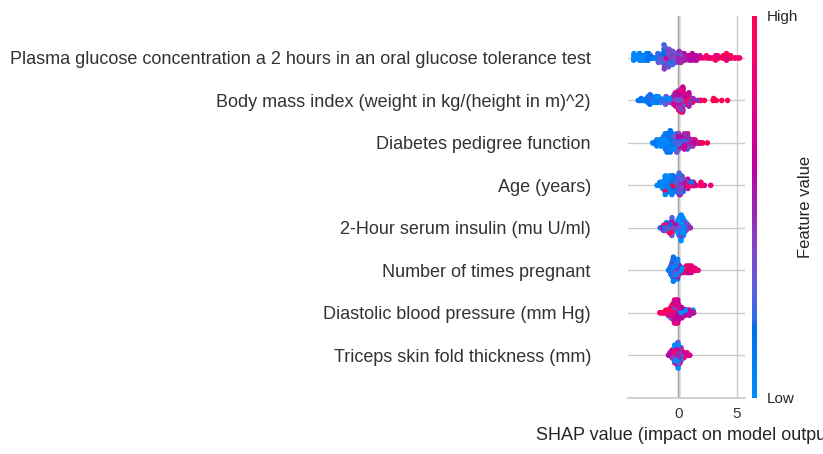

In [32]:
from pycaret.classification import *
clf = setup(data, target='Class variable', session_id=42)
best = create_model('xgboost')      # 任意树模型都行

# 1. 全局重要性
interpret_model(best)               # 条形图+点图

# 2. 单样本解释
interpret_model(best, plot='reason', observation=42)

In [53]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

run_id = None
# 列出模型所有版本
for mv in client.get_latest_versions("abc"):
    print(f"Version: {mv.version}, Stage: {mv.current_stage}, Run ID: {mv.run_id}")
    
    run_id = mv.run_id


Version: 3, Stage: None, Run ID: 1139ccb5e7804ab1a1ad5cee87fa9777


In [54]:
import mlflow.pyfunc
import pandas as pd

# 使用 Run ID 加载模型
# run_id = "1139ccb5e7804ab1a1ad5cee87fa9777"
model_uri = f"runs:/{run_id}/model"  # "model" 是默认模型保存路径
model = mlflow.pyfunc.load_model(model_uri)


import pandas as pd

# 1. 从本地 CSV 读取
test = pd.read_csv('diabetes.csv')   # 路径按实际修改
test = test.drop(columns=["Class variable"])
# 做预测
predictions = model.predict(test)
print(predictions)



[1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0
 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 0 1 0 0 0 

In [56]:
data

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
